# 未来TODO:
- ちょっと一回整理する！
- 不要コード除去する
- ベースラインモデルをつくってないので、
    - ここを作らないと特徴量エンジニアリングの効果がわかりにくい

# 特徴量エンジニアリング: Name と Ageであーだこーだ
- Nameから敬称を取得して、Ageの欠損を埋める
- Ageから区分を作る → e.g. Childとか


In [40]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook as tqdm

warnings.filterwarnings('ignore')


sns.set(style='white', context='notebook', palette='deep')
%matplotlib inline

In [41]:
def visualize_feature_importance(model, X_train):
    # barplotに持ち込むためのDFを生成
    df = pd.DataFrame()
    df['feature_name'] = X_train.columns
    df['feature_importance'] = model.feature_importances_

    # 降順のほうが見やすいのでソート
    df.sort_values(by='feature_importance', ascending=False, inplace=True)

    # 重要度0はノイズに思えるので除外している
    df = df[df['feature_importance'] > 0]

    sns.barplot(x='feature_importance',
                y='feature_name',
                data=df)

    plt.xlim(0, 1.0)

In [42]:
train = pd.read_csv('../input_data/train.csv')
test = pd.read_csv('../input_data/test.csv')

# この2つだけを見る
train = train[['Survived', 'Age', 'Name']]
test = test[['Name', 'Age']]


## 名前の構造が全て同様かを確かめるために、Nameがいくつの部分に分かれるかを調べる


In [43]:
train['NameParts'] = train['Name'].str.split(",").apply(lambda x: len(x))

train['NameParts'].value_counts()

2    891
Name: NameParts, dtype: int64

In [44]:
test['NameParts'] = test['Name'].str.split(",").apply(lambda x: len(x))

test['NameParts'].value_counts()

2    418
Name: NameParts, dtype: int64

In [45]:
# NamePartsはもう不要なので削除
train.drop('NameParts', axis=1, inplace=True)
test.drop('NameParts', axis=1, inplace=True)

## 名前の構造
![](https://img.esa.io/uploads/production/attachments/6586/2019/06/03/21054/6512c82a-d943-4c69-b3b2-6f90f4e5c9e7.png)

In [46]:
train['FamilyName'] = train['Name'].str.split(",").apply(lambda x: x[0])
train['Title'] = train['Name'].str.split(",").apply(lambda x: x[1].split(".")[0].strip())

train.head()

,Survived,Age,Name,FamilyName,Title
0,0,22.0,"Braund, Mr. Owen Harris",Braund,Mr
1,1,38.0,"Cumings, Mrs. John Bradley (Florence Briggs Th...",Cumings,Mrs
2,1,26.0,"Heikkinen, Miss. Laina",Heikkinen,Miss
3,1,35.0,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",Futrelle,Mrs
4,0,35.0,"Allen, Mr. William Henry",Allen,Mr


### Title(肩書)

In [47]:
train['Title'].value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Col               2
Major             2
Sir               1
Capt              1
Mme               1
the Countess      1
Lady              1
Jonkheer          1
Ms                1
Don               1
Name: Title, dtype: int64

## Ageが欠損しているが、Titleから欠損補完できる可能性

In [48]:
train.groupby('Title').mean()[['Age']]

,Age
Title,
Capt,70.000000
Col,58.000000
Don,40.000000
Dr,42.000000
Jonkheer,38.000000
Lady,48.000000
Major,48.500000
Master,4.574167
Miss,21.773973


# この段階で、trainとtestを混ぜても良い気がしてきたので最初からやる

In [49]:
train = pd.read_csv('../input_data/train.csv')
test = pd.read_csv('../input_data/test.csv')

train = train[['Survived', 'Age', 'Name']]
test = test[['Name', 'Age']]

data = pd.concat([train, test], axis=0)

data.head()

,Age,Name,Survived
0,22.0,"Braund, Mr. Owen Harris",0.0
1,38.0,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1.0
2,26.0,"Heikkinen, Miss. Laina",1.0
3,35.0,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1.0
4,35.0,"Allen, Mr. William Henry",0.0


## Name から Title 抽出

In [50]:
# Refactor: もっといけるやる
data['FamilyName'] = data['Name'].str.split(",").apply(lambda x: x[0])
data['Title'] = data['Name'].str.split(",").apply(lambda x: x[1].split(".")[0].strip())

data.head()

,Age,Name,Survived,FamilyName,Title
0,22.0,"Braund, Mr. Owen Harris",0.0,Braund,Mr
1,38.0,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1.0,Cumings,Mrs
2,26.0,"Heikkinen, Miss. Laina",1.0,Heikkinen,Miss
3,35.0,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1.0,Futrelle,Mrs
4,35.0,"Allen, Mr. William Henry",0.0,Allen,Mr


In [51]:
data['Title'].value_counts()

Mr              757
Miss            260
Mrs             197
Master           61
Dr                8
Rev               8
Col               4
Mlle              2
Major             2
Ms                2
the Countess      1
Mme               1
Jonkheer          1
Capt              1
Sir               1
Don               1
Lady              1
Dona              1
Name: Title, dtype: int64

## Title別のデータを観察する


In [81]:
# 件数5以下のものは平均をとっても意味がないと思ったので、除外して集約
target_titles = (data['Title'].value_counts() >= 5)[(data['Title'].value_counts() >= 5)].index.values

group_by_title = data[data['Title'].isin(target_titles)].groupby('Title')

In [82]:
# 平均をみる
group_by_title.mean()[['Age']]

,Age
Title,
Dr,43.571429
Master,5.482642
Miss,21.774238
Mr,32.252151
Mrs,36.994118
Rev,41.250000


In [83]:
# 中央値もみる → 平均とだいたい同じ
group_by_title.median()[['Age']]

,Age
Title,
Dr,49.0
Master,4.0
Miss,22.0
Mr,29.0
Mrs,35.5
Rev,41.5


In [84]:
# Titleごとの生存率 → 女性Title と 幼児(？)の生存率が高い
group_by_title.mean()[['Survived']].sort_values('Survived', ascending=False)

,Survived
Title,
Mrs,0.792000
Miss,0.697802
Master,0.575000
Dr,0.428571
Mr,0.156673
Rev,0.000000


In [85]:
# 5件未満のTitleはOtherとしてしまおう
def hoge(x):
    if x in target_titles:
        return x
    else:
        return 'Other'

data['Title'] = data['Title'].apply(hoge)
data['Title'].value_counts()

Mr        757
Miss      260
Mrs       197
Master     61
Other      18
Rev         8
Dr          8
Name: Title, dtype: int64

## ['Mr', 'Miss', 'Mrs', 'Master', 'Dr'] だけど、欠損があるやつ → 262/263 == 1件以外は補完できる！

In [86]:
data[data['Age'].isnull() & data['Title'].isin(target_titles)].shape[0]

262

In [87]:
data.isnull().sum()

Age           263
Name            0
Survived      418
FamilyName      0
Title           0
dtype: int64

### それでも補完できない2件は何か？

In [88]:
# それでも補完できない2件は何か？
data[data['Age'].isnull() & ~data['Title'].isin(target_titles)]

,Age,Name,Survived,FamilyName,Title
88,NaN,"O'Donoghue, Ms. Bridget",NaN,O'Donoghue,Other


# 実際に補完する

In [89]:
# Refactor: ゴリ押しがすぎる
"""
Dr        43.571429
Master     5.482642
Miss      21.774238
Mr        32.252151
Mrs       36.994118
"""



def fill_age_from_title_avg(x: float):
    if not x.isnull().any(): # TODO: これだと何かだめ → x[0] != np.nan: 
        return x[0]
    if x[1] == 'Dr': return 43.571429
    if x[1] == 'Master': return  5.482642
    if x[1] == 'Miss': return 21.774238
    if x[1] == 'Mr':return 32.252151
    if x[1] == 'Mrs': return  36.994118  
    

data['FilledAge'] = data[['Age', 'Title']].apply(fill_age_from_title_avg, axis=1)
data['FilledAge'] = data['FilledAge'].round(2) # みづらいので桁調整(小数点に影響があるとも考えにくいし)
data['FilledAge'] = data['FilledAge'].fillna(value=data['FilledAge'].mean()) # 1件の欠損は平均埋(Ms)

In [90]:
data[data['Title'].isin(target_titles)].groupby('Title').mean()['Age']

Title
Dr        43.571429
Master     5.482642
Miss      21.774238
Mr        32.252151
Mrs       36.994118
Rev       41.250000
Name: Age, dtype: float64

# 補完後の分布をもとの分布と比べてみる(変に欠損補完をしてないか？)

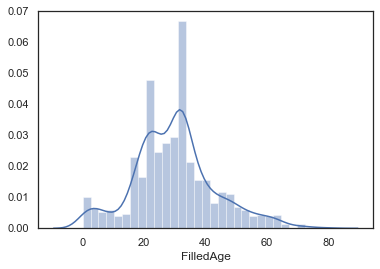

In [91]:
sns.distplot(data['FilledAge'])

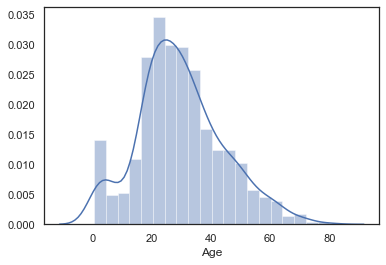

In [92]:
sns.distplot(train['Age'].dropna())

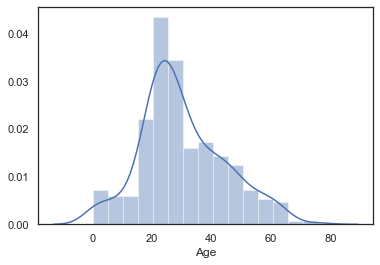

In [93]:
sns.distplot(test['Age'].dropna())

# ここでTrainとTestを分離しておく

In [94]:
train = data[data['Survived']>=0].copy()
test = data[data['Survived'].isnull()].copy()

# 行数で確認
train.shape[0], test.shape[0]

(891, 418)

In [95]:
# 必要なカラムだけ残す
train = train[['Survived', 'Title', 'FilledAge']]
train['Survived'] = train['Survived'].astype(int)

test = test[['Title', 'FilledAge']]

# 年齢による区分を考える

## TODO: 仮説！ 子供とおとなと 老人でわけたい


In [96]:
# Refactor: もっとかっこよくしたいね。よく使う記述だし。
def to_age_category(x: float):
    if x < 10:
        return '0代'
    if 10 <= x < 20:
        return '10代'
    if 20 <= x < 30:
        return '20代'
    if 30 <= x < 40:
        return '30代'
    if 40 <= x < 50:
        return '40代'
    if 50 <= x < 60:
        return '50代'
    if 60 <= x:
        return '60代以上'
        
train['FilledAgeCategory'] = train['FilledAge'].apply(to_age_category)

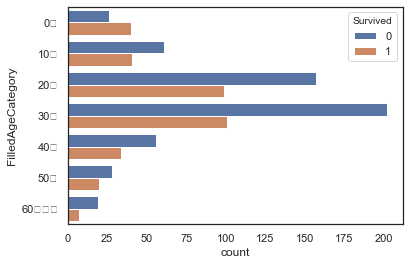

In [97]:
# TODO: 帯グラフの方が見やすいけど、やりかたわからん
sns.countplot(y='FilledAgeCategory',
              hue='Survived',
              data=train,
              order=['0代', '10代', '20代', '30代', '40代', '50代', '60代以上'],
              orient='horizontal')

In [98]:
train.head()

,Survived,Title,FilledAge,FilledAgeCategory
0,0,Mr,22.0,20代
1,1,Mrs,38.0,30代
2,1,Miss,26.0,20代
3,1,Mrs,35.0,30代
4,0,Mr,35.0,30代


# 適当に予測モデルつくる(ほんと、てきとー)- 

In [99]:
X_train = train.drop(columns=['Survived','FilledAge'], axis=1)
X_train['Sex'] = pd.read_csv('../input_data/train.csv', usecols=['Sex'])
X_train = pd.get_dummies(X_train, drop_first=True)

y_train = train['Survived'].copy()

X_train.head(1)

,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Other,Title_Rev,FilledAgeCategory_10代,FilledAgeCategory_20代,FilledAgeCategory_30代,FilledAgeCategory_40代,FilledAgeCategory_50代,FilledAgeCategory_60代以上,Sex_male
0,0,0,1,0,0,0,0,1,0,0,0,0,1


In [100]:
from sklearn.tree import DecisionTreeClassifier

tree_model = DecisionTreeClassifier(criterion='gini',
                                    splitter='best',
                                    max_depth=10)

tree_model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [101]:
from sklearn.metrics import roc_auc_score

pred = tree_model.predict_proba(X_train)[:, 1]
roc_auc_score(y_train, pred)

0.8269527796418795

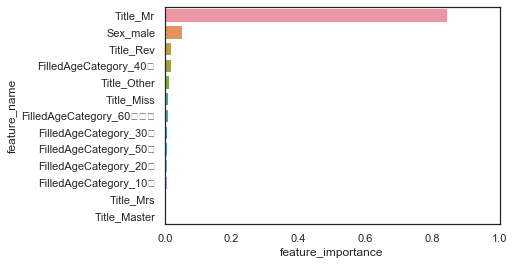

In [102]:
# 件数が少ない Title は other deまとめていいと思う？
visualize_feature_importance(tree_model, X_train)

## SubmitDataつくり

In [103]:
test['FilledAgeCategory'] = test['FilledAge'].apply(to_age_category)

X_test = test.drop(columns=['FilledAge'])
X_test['Sex'] = pd.read_csv('../input_data/test.csv', usecols=['Sex'])
X_test = pd.get_dummies(X_test, drop_first=True)

X_test.head()

,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Other,Title_Rev,FilledAgeCategory_10代,FilledAgeCategory_20代,FilledAgeCategory_30代,FilledAgeCategory_40代,FilledAgeCategory_50代,FilledAgeCategory_60代以上,Sex_male
0,0,0,1,0,0,0,0,0,1,0,0,0,1
1,0,0,0,1,0,0,0,0,0,1,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,1,1
3,0,0,1,0,0,0,0,1,0,0,0,0,1
4,0,0,0,1,0,0,0,1,0,0,0,0,0


In [105]:
submit_data = pd.read_csv('../input_data/test.csv', usecols=['PassengerId'])
submit_data['Survived'] = tree_model.predict(X_test)

# スコア: 0.73684 -> 0.77033
submit_data.to_csv('tree_model_FilledAgeCategory_Title.csv', index=False)